In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from fbprophet import Prophet

import xgboost as xgb
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
store = pd.read_csv("dataset/store.csv")
train = pd.read_csv("dataset/train.csv")

C:\Users\Hitesh\AppData\Local\Temp\ipykernel_20284\2619425430.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("dataset/train.csv")


<Axes: >

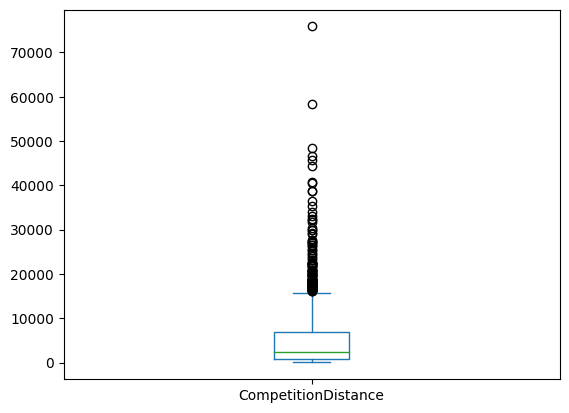

In [3]:
store.CompetitionDistance.plot.box() 

In [4]:
store["CompetitionDistance"].fillna(store["CompetitionDistance"].median(), inplace = True)
store["CompetitionOpenSinceMonth"].fillna(0, inplace = True)
store["CompetitionOpenSinceYear"].fillna(0, inplace = True)

In [5]:
store.groupby(by = "Promo2", axis = 0).count() 

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Promo2,,,,,,,,,
0,544,544,544,544,544,544,0,0,0
1,571,571,571,571,571,571,571,571,571


In [6]:
store["Promo2SinceWeek"].fillna(0, inplace = True)
store["Promo2SinceYear"].fillna(0, inplace = True)
store["PromoInterval"].fillna(0, inplace = True)

In [7]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [8]:
# encoding stateholiday
train["StateHoliday_cat"] = train["StateHoliday"].map({0:0, "0": 0, "a": 1, "b": 1, "c": 1})
train.StateHoliday_cat.count()

1017209

In [9]:
train = train.drop("StateHoliday", axis = 1)
# train.tail()

In [10]:
#lets delete the times, where the stores were opened with no sales because of days in inventory.
train = train.drop(train[(train.Open == 0) & (train.Sales == 0)].index)
train = train.reset_index(drop = True) # to ge the indexes back to 0, 1, 2,etc.

In [11]:
train_store = pd.merge(train, store, how = "left", on = "Store")
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844392 non-null  int64  
 1   DayOfWeek                  844392 non-null  int64  
 2   Date                       844392 non-null  object 
 3   Sales                      844392 non-null  int64  
 4   Customers                  844392 non-null  int64  
 5   Open                       844392 non-null  int64  
 6   Promo                      844392 non-null  int64  
 7   SchoolHoliday              844392 non-null  int64  
 8   StateHoliday_cat           844392 non-null  int64  
 9   StoreType                  844392 non-null  object 
 10  Assortment                 844392 non-null  object 
 11  CompetitionDistance        844392 non-null  float64
 12  CompetitionOpenSinceMonth  844392 non-null  float64
 13  CompetitionOpenSinceYear   84

In [12]:
train_store.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
SchoolHoliday                0
StateHoliday_cat             0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [13]:
train_store.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_cat,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.0,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,1.0,0.446352,0.193580,0.001078,5449.868829,4.926491,1369.688401,0.498684,11.596118,1003.230065
std,321.731914,1.723689,3104.214680,401.227674,0.0,0.497114,0.395103,0.032811,7800.946702,4.283663,935.558173,0.499999,15.307873,1005.874806
min,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,1.0,0.000000,0.000000,0.000000,710.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,1.0,0.000000,0.000000,0.000000,2325.000000,4.000000,2006.000000,0.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.0,1.000000,0.000000,0.000000,6880.000000,9.000000,2011.000000,1.000000,22.000000,2012.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.0,1.000000,1.000000,1.000000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [14]:
train_store["Avg_Customer_Sales"] = train_store.Sales / train_store.Customers

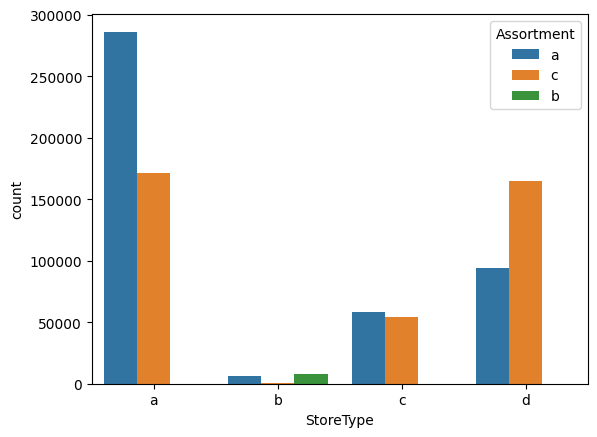

In [19]:
sns.countplot(data = train_store, x = "StoreType", hue = "Assortment", order=["a","b","c","d"]) 
plt.show()

#### StoreType B has all assortments. 

#### The assortment C is better, because the StoreType D has the best average customer spending.

In [21]:
# formating temporal data
train_store.Date = train_store.Date.astype("datetime64[ns]")

train_store["Month"] = train_store.Date.dt.month
train_store["Year"] = train_store.Date.dt.year
train_store["Day"] = train_store.Date.dt.day

In [22]:
train_store.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'StateHoliday_cat', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Avg_Customer_Sales', 'Month',
       'Year', 'Day'],
      dtype='object')

In [23]:
# The obsverations are continous numbers, so we need to convert them into a categories
train_store["CompetitionDistance_Cat"] = pd.cut(train_store["CompetitionDistance"], 5)

In [24]:
# convert datatype
# convert variables to categorical

train_store["StoreType"] = train_store["StoreType"].astype("category")
train_store["Assortment"] = train_store["Assortment"].astype("category")
train_store["PromoInterval"] = train_store["PromoInterval"].astype("category")

train_store["StoreType_cat"] = train_store["StoreType"].cat.codes
train_store["Assortment_cat"] = train_store["Assortment"].cat.codes
train_store["PromoInterval_cat"] = train_store["Assortment"].cat.codes

train_store["StateHoliday_cat"] = train_store["StateHoliday_cat"].astype("float")
train_store["StoreType_cat"] = train_store["StoreType_cat"].astype("float")
train_store["Assortment_cat"] = train_store["Assortment_cat"].astype("float")
train_store["PromoInterval_cat"] = train_store["PromoInterval_cat"].astype("float")

## Random Forest Regression

In [25]:
train_store["CompetitionOpenSince"] = np.where((train_store["CompetitionOpenSinceMonth"] == 0) & (train_store["CompetitionOpenSinceYear"] == 0), 
                                                0,(train_store.Month - train_store.CompetitionOpenSinceMonth) + (12 *(train_store.Year - train_store.CompetitionOpenSinceYear)))

# drop the variables
train_store = train_store.drop(["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"], axis = 1)

In [26]:
# drop variables, that either or not numeric or we dont need them anymore
# create a new data frame for this model
trainstore_rf = train_store.copy()
trainstore_rf = train_store.drop(["Date","StoreType", "Assortment", "PromoInterval", "CompetitionDistance_Cat"], axis = 1) #dop this columns, as we already have them in categories

In [31]:
features = trainstore_rf.drop(["Customers", "Sales", "Avg_Customer_Sales"], axis = 1)
target = trainstore_rf["Sales"]

X_train, X_train_test, y_train, y_train_test = model_selection.train_test_split(features, target, test_size = 0.20, random_state = 15) 

print(X_train.shape, X_train_test.shape, y_train.shape, y_train_test.shape)

(675513, 17) (168879, 17) (675513,) (168879,)


In [32]:
from sklearn.ensemble import RandomForestRegressor

regts = RandomForestRegressor(n_estimators=10)
regts.fit(X_train, y_train)
yhat = regts.predict(X_train_test)

In [34]:
rms = sqrt(mean_squared_error(y_train_test, yhat))
print("RMS:", rms)

RMS: 979.2188344107592


In [35]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [36]:
param = {'max_depth':10, 
         "booster": "gbtree",   
         'eta':1, 
         'silent':1, 
         'objective':'reg:linear'
        }

#define number of boosting rounds
num_round = 100 

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_train_test, y_train_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

xgboost = xgb.train(param, dtrain, num_round, evals=watchlist, \
  early_stopping_rounds= 100, feval=rmspe_xg, verbose_eval=True)
         
# make prediction
preds = xgboost.predict(dtest)

C:\Users\Hitesh\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
C:\Users\Hitesh\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [01:12:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
C:\Users\Hitesh\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [01:12:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Par

[0]	train-rmse:2178.34574	train-rmspe:nan	eval-rmse:2190.39264	eval-rmspe:nan
[1]	train-rmse:2058.34517	train-rmspe:nan	eval-rmse:2080.39838	eval-rmspe:nan
[2]	train-rmse:1691.28383	train-rmspe:nan	eval-rmse:1710.25957	eval-rmspe:nan
[3]	train-rmse:1586.89091	train-rmspe:nan	eval-rmse:1608.86923	eval-rmspe:nan
[4]	train-rmse:1451.21918	train-rmspe:nan	eval-rmse:1475.90850	eval-rmspe:nan
[5]	train-rmse:1390.57102	train-rmspe:nan	eval-rmse:1419.20575	eval-rmspe:nan
[6]	train-rmse:1318.16227	train-rmspe:nan	eval-rmse:1353.72246	eval-rmspe:nan
[7]	train-rmse:1266.66342	train-rmspe:nan	eval-rmse:1306.48351	eval-rmspe:nan
[8]	train-rmse:1180.46925	train-rmspe:nan	eval-rmse:1226.91114	eval-rmspe:nan
[9]	train-rmse:1140.16038	train-rmspe:nan	eval-rmse:1191.53444	eval-rmspe:nan
[10]	train-rmse:1114.72467	train-rmspe:nan	eval-rmse:1171.23067	eval-rmspe:nan
[11]	train-rmse:1093.99666	train-rmspe:nan	eval-rmse:1153.20889	eval-rmspe:nan
[12]	train-rmse:1059.45095	train-rmspe:nan	eval-rmse:1122.6202

C:\Users\Hitesh\AppData\Local\Temp\ipykernel_20284\159883851.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt(np.mean((yhat/y-1) ** 2))


[60]	train-rmse:691.77733	train-rmspe:nan	eval-rmse:894.73859	eval-rmspe:nan
[61]	train-rmse:689.94487	train-rmspe:nan	eval-rmse:894.62436	eval-rmspe:nan
[62]	train-rmse:686.02656	train-rmspe:nan	eval-rmse:892.91767	eval-rmspe:nan
[63]	train-rmse:683.71878	train-rmspe:nan	eval-rmse:892.42699	eval-rmspe:nan
[64]	train-rmse:679.95008	train-rmspe:nan	eval-rmse:890.66140	eval-rmspe:nan
[65]	train-rmse:678.57339	train-rmspe:nan	eval-rmse:890.65458	eval-rmspe:nan
[66]	train-rmse:675.46546	train-rmspe:nan	eval-rmse:889.56592	eval-rmspe:nan
[67]	train-rmse:670.70357	train-rmspe:nan	eval-rmse:887.13062	eval-rmspe:nan
[68]	train-rmse:668.33102	train-rmspe:nan	eval-rmse:886.92451	eval-rmspe:nan
[69]	train-rmse:664.38577	train-rmspe:nan	eval-rmse:885.26887	eval-rmspe:nan
[70]	train-rmse:661.67044	train-rmspe:nan	eval-rmse:884.24441	eval-rmspe:nan
[71]	train-rmse:659.04306	train-rmspe:nan	eval-rmse:883.93075	eval-rmspe:nan
[72]	train-rmse:656.90489	train-rmspe:nan	eval-rmse:883.61605	eval-rmspe:nan

In [37]:
rms_xgboost = sqrt(mean_squared_error(y_train_test, preds))
print("RMS:", rms_xgboost) 

RMS: 873.0114320856579


In [38]:
# compare

model_errors = pd.DataFrame({
    "Model": [ "Random Forest Regression", "XGBoost"],
    "Score": [ rms, rms_xgboost]
})

model_errors.sort_values(by = "Score", ascending = True)

,Model,Score
1,XGBoost,873.011432
0,Random Forest Regression,979.218834
